In [10]:
!cd ../ && python scripts/inference.py --data /data/private_data/13_3d --dim 3 --fold 0 --ckpt_path /results/glioma_results/checkpoints/epoch=118-dice_mean=97.06.ckpt --amp --tta --save_preds

Global seed set to 1
0 training, 0 validation, 370 test examples
Filters: [64, 96, 128, 192, 256, 384, 512],
Kernels: [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
Strides: [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Testing: 100%|██████████████████████████████| 370/370 [1:13:02<00:00, 11.84s/it]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


In [34]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import nibabel as nib    
from pathlib import Path
from surface_distance import metrics
from tqdm import tqdm



def sensitivity_and_specificity(mask_gt, mask_pred):
    """ Computes sensitivity and specificity
     sensitivity  = TP/(TP+FN)
     specificity  = TN/(TN+FP) """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    tp = (mask_gt & mask_pred).sum()
    tn = (~mask_gt & ~mask_pred).sum()
    fp = (~mask_gt & mask_pred).sum()
    fn = (mask_gt & ~mask_pred).sum()
#     TP/(TP+FP) - precision; TP/(TP+FN) - recall
    return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)


def calculate_metrics_brats(true_mask, pred_mask, ids, spaces):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Ids', 'Dice_all','Dice_0', 'Dice_1', 'Dice_2', 'Dice_3',
               'Hausdorff95_all', 'Hausdorff95_0', 'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_4',
               'Sensitivity_all','Sensitivity_0', 'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_4',
               'Specificity_all','Specificity_0', 'Specificity_1', 'Specificity_2', 'Specificity_4',
               'Surface_dice_all','Surface_dice_0', 'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_4',
               'Precision_all', 'Precision_0', 'Precision_1', 'Precision_2', 'Precision_4']
    
    df = pd.DataFrame(columns = _columns)
    df.at[0,'Ids'] = ids
    #class 1
    distances = metrics.compute_surface_distances((true_mask!=1), (pred_mask[0,:,:,:]==1), spaces)
    df.at[0,'Dice_1'] = metrics.compute_dice_coefficient((true_mask!=1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Surface_dice_1'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec = sensitivity_and_specificity((true_mask!=1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Sensitivity_1'] = sens
    df.at[0,'Precision_1'] = precision
    df.at[0,'Specificity_1'] = spec
    #class 2
    distances = metrics.compute_surface_distances((true_mask==1), (pred_mask[1,:,:,:]==1), spaces)
    df.at[0,'Dice_2'] = metrics.compute_dice_coefficient((true_mask==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Surface_dice_2'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_2'] = metrics.compute_robust_hausdorff(distances, 95)
    sens,precision, spec= sensitivity_and_specificity((true_mask==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Sensitivity_2'] = sens
    df.at[0,'Precision_2'] = precision
    df.at[0,'Specificity_2'] = spec
    #class 3
#     distances = metrics.compute_surface_distances((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1), spaces)
#     df.at[0,'Dice_4'] = metrics.compute_dice_coefficient((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
#     df.at[0,'Surface_dice_4'] = metrics.compute_surface_dice_at_tolerance(distances,1)
#     df.at[0,'Hausdorff95_4'] = metrics.compute_robust_hausdorff(distances, 95)
#     sens, precision, spec= sensitivity_and_specificity((true_mask[2,:,:,:]==1), (pred_mask[2,:,:,:]==1))
#     df.at[0,'Sensitivity_4'] = sens
#     df.at[0,'Precision_4'] = precision
#     df.at[0,'Specificity_4'] = spec
    return df

def get_stats(preds, target, class_idx):
        tp = torch.logical_and(preds == class_idx, target == class_idx).sum()
        fn = torch.logical_and(preds != class_idx, target == class_idx).sum()
        fp = torch.logical_and(preds == class_idx, target != class_idx).sum()
        return tp, fn, fp

    
def compute_stats_brats( p, y):
        scores = torch.zeros(3, device=p.device, dtype=torch.float32)
        p = (torch.sigmoid(p) > 0.5).int()
        y_wt, y_tc, y_et = y > 0, ((y == 1) + (y == 3)) > 0, y == 3
        y = torch.stack([y_wt, y_tc, y_et], dim=1)

        for i in range(3):
            p_i, y_i = p[:, i], y[:, i]
            if (y_i != 1).all():
                # no foreground class
                scores[i - 1] += 1 if (p_i != 1).all() else 0
                continue
            tp, fn, fp = get_stats(p_i, y_i, 1)
            denom = (2 * tp + fp + fn).to(torch.float)
            score_cls = (2 * tp).to(torch.float) / denom if torch.is_nonzero(denom) else 0.0
            scores[i - 1] += score_cls
        return scores
    
def calculate_metrics(path_to_pred, path_to_target, spaces = True, name_csv='dice_metrics.csv', path_csv_all = '/home/polina/glioma/all_dice_metrics.csv'  ):
    
    """ 
    - path_to_pred - path to folder with predict subjects
    - path_to_target - path to folder with target subjects
    - name_pred - name for prediction, ex -brainTumorMask_SRI.nii.gz
    - name_target - name for targets, ex -GTV_to_SRI.nii.gz
    - spaces - if false - [1,1,1]
    - name_csv - name files for each subjects
    - path_csv_all - path to the main file with metrics for each subjects
    """
    _columns = ['Ids', 'Dice_all','Dice_0', 'Dice_1', 'Dice_2', 'Dice_3',
               'Hausdorff95_all', 'Hausdorff95_0', 'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_4',
               'Sensitivity_all','Sensitivity_0', 'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_4',
               'Specificity_all','Specificity_0', 'Specificity_1', 'Specificity_2', 'Specificity_4',
               'Surface_dice_all','Surface_dice_0', 'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_4',
               'Precision_all', 'Precision_0', 'Precision_1', 'Precision_2', 'Precision_4']
    af_all = pd.DataFrame(columns = _columns)
    pred_folder = Path(path_to_pred)
    target_folder = Path(path_to_target)
    for ids in tqdm(os.listdir(pred_folder)):
        sub = ids[:-4]
        targets = nib.load(target_folder /  f'{sub}_seg.nii.gz').get_fdata()
#         y_wt, y_tc, y_et = targets > 0, ((targets == 1) + (targets == 3)) > 0, targets == 3
#         targets = np.stack([y_wt, y_tc, y_et], axis=0).astype(int)
        predictions = np.load((os.path.join(path_pred, ids)))
        spaces = [1,1,1]
        pred = np.round(predictions, 0)
        pred = np.transpose(pred, (0, 3, 2, 1))
#         print(targets.shape), print(pred.shape)
#         print(np.unique(targets)), print(np.unique(pred))
        df=calculate_metrics_brats(targets.astype('int'), pred.astype('int'), sub, spaces)
#         print(df)
        af_all = af_all.append(df)
    af_all.to_csv('all_metris_glioma.csv')  
    print(af_all.mean())

In [35]:
path_pred='/results/predictions_epoch=118-dice_mean=97_06_task=13_fold=0_tta'
path_target='/data/private_data/brats_pipeline_out_train/labels'
calculate_metrics(path_pred, path_target)

 72%|████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 267/370 [33:08<12:26,  7.24s/it]/tmp/ipykernel_499/80647080.py:23: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 370/370 [45:00<00:00,  7.30s/it]

Dice_all                 NaN
Dice_0                   NaN
Dice_1              0.968174
Dice_2              0.976214
Dice_3                   NaN
Hausdorff95_all          NaN
Hausdorff95_0            NaN
Hausdorff95_1       6.429240
Hausdorff95_2            inf
Hausdorff95_4            NaN
Sensitivity_all          NaN
Sensitivity_0            NaN
Sensitivity_1       0.944425
Sensitivity_2       0.984321
Sensitivity_4            NaN
Specificity_all          NaN
Specificity_0            NaN
Specificity_1       0.984321
Specificity_2       0.995865
Specificity_4            NaN
Surface_dice_all         NaN
Surface_dice_0           NaN
Surface_dice_1      0.854068
Surface_dice_2      0.885829
Surface_dice_4           NaN
Precision_all            NaN
Precision_0              NaN
Precision_1         0.997057
Precision_2         0.973354
Precision_4              NaN
dtype: float64


1019_18
(240, 240)
(240, 240)
[0 1]
[0 1 2 4]


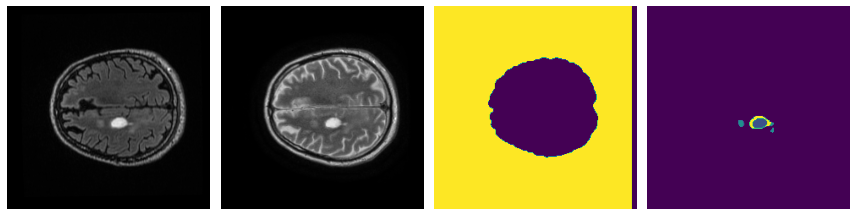

1028_18_4
(240, 240)
(240, 240)
[0 1]
[0]


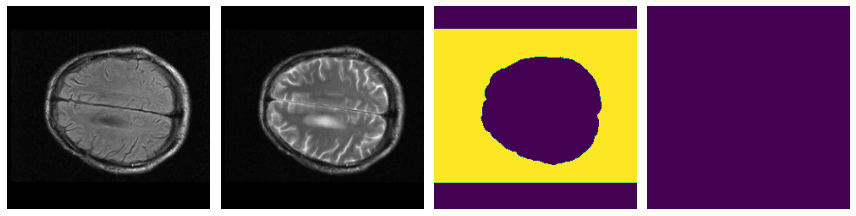

1029_18_4
(240, 240)
(240, 240)
[0 1]
[0]


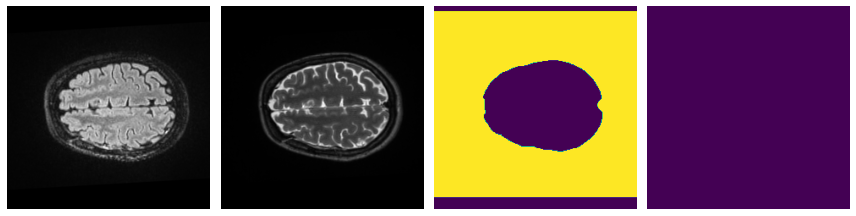

102_19_4
(240, 240)
(240, 240)
[0 1]
[0]


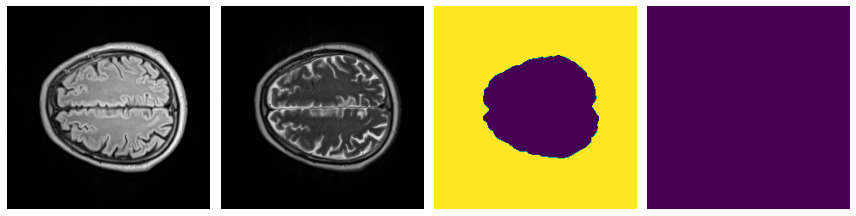

1032_19
(240, 240)
(240, 240)
[0 1]
[0]


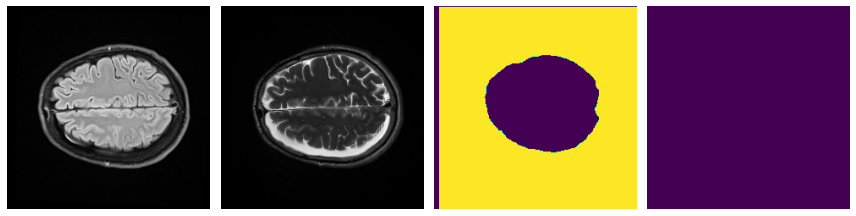

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 5, 107
data = sorted(glob("/results/predictions_epoch=118-dice_mean=97_06_task=13_fold=0_tta/*.npy"))
for i in range(n):
    fname = data[i].split("/")[-1].split(".")[0]
    print(fname)
    img = nib.load(f"/data/private_data/brats_pipeline_out_train/images/{fname}.nii.gz").get_fdata().astype(np.float32)
    label = nib.load(f"/data/private_data/brats_pipeline_out/{fname}/brainTumorMask_SRI.nii.gz").get_fdata().astype(np.uint8)[:, :, z]
    pred = np.load(data[i])
    pred = to_lbl(pred)[:, :, z]
#     pred = np.round(pred, 0).transpose(3,2,1,0)
    print(label.shape), print(pred.shape)
    print(np.unique(pred)), print(np.unique(label))
    imgs = [img[:, :, z, i] for i in [0, 3]] + [pred] + [label]    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
    for i in range(4):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()

1019_18
(240, 240)
(240, 240)
[0 1]
[0 1]


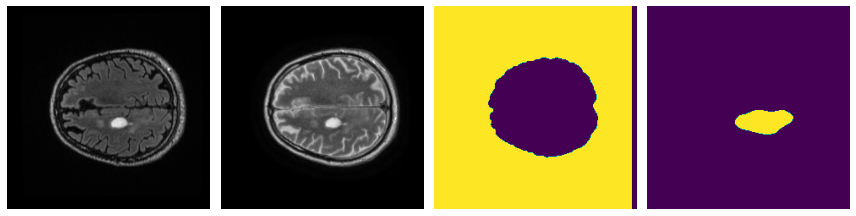

1028_18_4
(240, 240)
(240, 240)
[0 1]
[0]


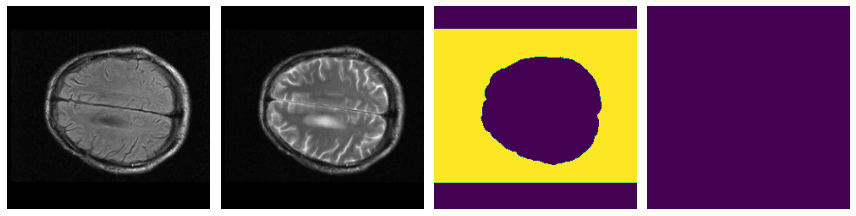

1029_18_4
(240, 240)
(240, 240)
[0 1]
[0]


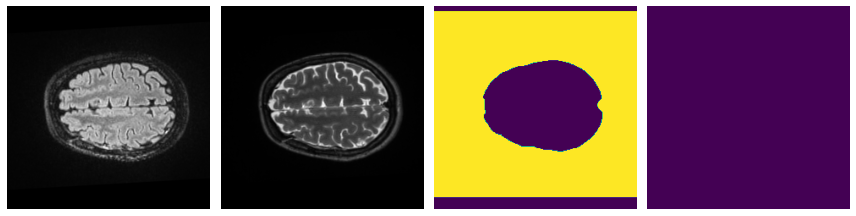

102_19_4
(240, 240)
(240, 240)
[0 1]
[0]


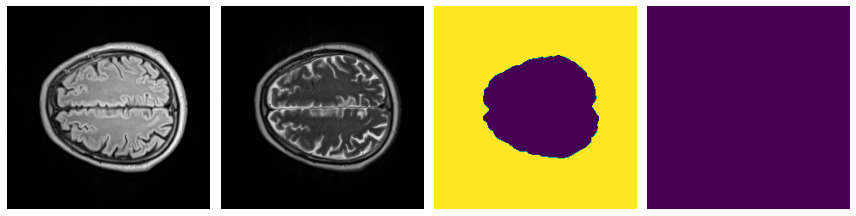

1032_19
(240, 240)
(240, 240)
[0 1]
[0]


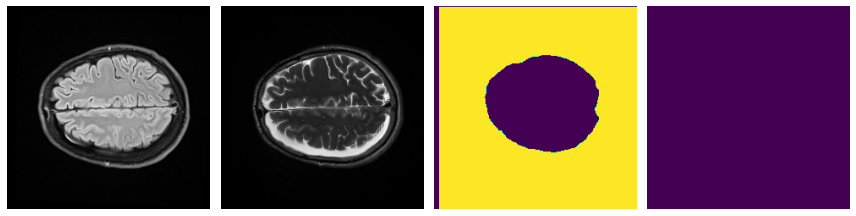

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 5, 107
data = sorted(glob("/results/predictions_epoch=118-dice_mean=97_06_task=13_fold=0_tta/*.npy"))
for i in range(n):
    fname = data[i].split("/")[-1].split(".")[0]
    print(fname)
    img = nib.load(f"/data/private_data/brats_pipeline_out_train_GTV/images/{fname}.nii.gz").get_fdata().astype(np.float32)
    label = nib.load(f"/data/private_data/brats_pipeline_out_train_GTV/labels/{fname}_seg.nii.gz").get_fdata().astype(np.uint8)[:, :, z]
    pred = np.load(data[i])
    pred = to_lbl(pred)[:, :, z]
#     pred = np.round(pred, 0).transpose(3,2,1,0)
    print(label.shape), print(pred.shape)
    print(np.unique(pred)), print(np.unique(label))
    imgs = [img[:, :, z, i] for i in [0, 3]] + [pred] + [label]    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
    for i in range(4):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()

In [11]:
!cd  /home/polina/project_style && tar -xf style_adni.tar.gz

In [51]:
!nvidia-smi

Wed Jan 26 09:17:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:21:01.0 Off |                    0 |
| N/A   33C    P0    24W / 250W |      4MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:21:02.0 Off |                    0 |
| N/A   

In [52]:
!cd ../ && export CUDA_VISIBLE_DEVICES=0 && python main.py --exec_mode predict --task 15 --brats --data /data/private_data/15_3d --dim 3 --fold 0 --nfolds 3 --ckpt_path /home/polina/DeepLearningExamples/PyTorch/Segmentation/nnUNet/results/3_fold_brats_2021/fold-0/checkpoints/epoch=135-dice_mean=90.62.ckpt --results /results/glioma_infer/glioma_brats_inference --amp --tta --save_preds

Global seed set to 1
0 training, 0 validation, 277 test examples
Filters: [64, 96, 128, 192, 256, 384, 512],
Kernels: [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]
Strides: [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Testing: 100%|████████████████████████████████| 277/277 [26:52<00:00,  5.82s/it]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


In [16]:
!cd /results/glioma_infer && ls

finetune	    fold-1_brats_brain	glioma_brats_inference
fold-0_brats_brain  fold-2_brats_brain


In [49]:
!cd /home/polina/DeepLearningExamples/PyTorch/Segmentation/nnUNet/results/3_fold_brats_2021/fold-0/checkpoints && ls

'epoch=135-dice_mean=90.62.ckpt'  'epoch=54-dice_mean=89.92.ckpt'
'epoch=48-dice_mean=89.76.ckpt'   'epoch=59-dice_mean=90.00.ckpt'
'epoch=50-dice_mean=89.49.ckpt'   'epoch=80-dice_mean=90.27.ckpt'
'epoch=53-dice_mean=89.93.ckpt'    last.ckpt


In [58]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import nibabel as nib    
from pathlib import Path
from surface_distance import metrics
from tqdm import tqdm



def sensitivity_and_specificity(mask_gt, mask_pred):
    """ Computes sensitivity and specificity
     sensitivity  = TP/(TP+FN)
     specificity  = TN/(TN+FP) """
    volume_sum = mask_gt.sum() + mask_pred.sum()
    tp = (mask_gt & mask_pred).sum()
    tn = (~mask_gt & ~mask_pred).sum()
    fp = (~mask_gt & mask_pred).sum()
    fn = (mask_gt & ~mask_pred).sum()
#     TP/(TP+FP) - precision; TP/(TP+FN) - recall
    return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)


def calculate_metrics_brats(true_mask, pred_mask, ids, spaces):
    """ Takes two file locations as input and validates surface distances.
    Be careful with dimensions of saved `pred` it should be 3D.
    
    """
    
    _columns = ['Ids', 'Dice_1', 'Dice_2', 'Dice_4',
                'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_4',
               'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_4',
               'Specificity_1', 'Specificity_2', 'Specificity_4',
               'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_4',
              'Precision_1', 'Precision_2', 'Precision_4']
    
    df = pd.DataFrame(columns = _columns)
    df.at[0,'Ids'] = ids
    #class 1
    distances = metrics.compute_surface_distances((true_mask==1), (pred_mask[0,:,:,:]==1), spaces)
    df.at[0,'Dice_1'] = metrics.compute_dice_coefficient((true_mask==1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Surface_dice_1'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_1'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec = sensitivity_and_specificity((true_mask==1), (pred_mask[0,:,:,:]==1))
    df.at[0,'Sensitivity_1'] = sens
    df.at[0,'Precision_1'] = precision
    df.at[0,'Specificity_1'] = spec
    #class 2
    distances = metrics.compute_surface_distances((true_mask==1), (pred_mask[1,:,:,:]==1), spaces)
    df.at[0,'Dice_2'] = metrics.compute_dice_coefficient((true_mask==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Surface_dice_2'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_2'] = metrics.compute_robust_hausdorff(distances, 95)
    sens,precision, spec= sensitivity_and_specificity((true_mask==1), (pred_mask[1,:,:,:]==1))
    df.at[0,'Sensitivity_2'] = sens
    df.at[0,'Precision_2'] = precision
    df.at[0,'Specificity_2'] = spec
    #class 3
    distances = metrics.compute_surface_distances((true_mask==1), (pred_mask[2,:,:,:]==1), spaces)
    df.at[0,'Dice_4'] = metrics.compute_dice_coefficient((true_mask==1), (pred_mask[2,:,:,:]==1))
    df.at[0,'Surface_dice_4'] = metrics.compute_surface_dice_at_tolerance(distances,1)
    df.at[0,'Hausdorff95_4'] = metrics.compute_robust_hausdorff(distances, 95)
    sens, precision, spec= sensitivity_and_specificity((true_mask==1), (pred_mask[2,:,:,:]==1))
    df.at[0,'Sensitivity_4'] = sens
    df.at[0,'Precision_4'] = precision
    df.at[0,'Specificity_4'] = spec
    return df

def get_stats(preds, target, class_idx):
        tp = torch.logical_and(preds == class_idx, target == class_idx).sum()
        fn = torch.logical_and(preds != class_idx, target == class_idx).sum()
        fp = torch.logical_and(preds == class_idx, target != class_idx).sum()
        return tp, fn, fp

    
def compute_stats_brats( p, y):
        scores = torch.zeros(3, device=p.device, dtype=torch.float32)
        p = (torch.sigmoid(p) > 0.5).int()
        y_wt, y_tc, y_et = y > 0, ((y == 1) + (y == 3)) > 0, y == 3
        y = torch.stack([y_wt, y_tc, y_et], dim=1)

        for i in range(3):
            p_i, y_i = p[:, i], y[:, i]
            if (y_i != 1).all():
                # no foreground class
                scores[i - 1] += 1 if (p_i != 1).all() else 0
                continue
            tp, fn, fp = get_stats(p_i, y_i, 1)
            denom = (2 * tp + fp + fn).to(torch.float)
            score_cls = (2 * tp).to(torch.float) / denom if torch.is_nonzero(denom) else 0.0
            scores[i - 1] += score_cls
        return scores
    
def calculate_metrics(path_to_pred, path_to_target, spaces = True, name_csv='dice_metrics.csv', path_csv_all = '/home/polina/glioma/all_dice_metrics.csv'  ):
    
    """ 
    - path_to_pred - path to folder with predict subjects
    - path_to_target - path to folder with target subjects
    - name_pred - name for prediction, ex -brainTumorMask_SRI.nii.gz
    - name_target - name for targets, ex -GTV_to_SRI.nii.gz
    - spaces - if false - [1,1,1]
    - name_csv - name files for each subjects
    - path_csv_all - path to the main file with metrics for each subjects
    """
    _columns = ['Ids', 'Dice_1', 'Dice_2', 'Dice_4',
               'Hausdorff95_1', 'Hausdorff95_2', 'Hausdorff95_4',
               'Sensitivity_1', 'Sensitivity_2', 'Sensitivity_4',
               'Specificity_1', 'Specificity_2', 'Specificity_4',
               'Surface_dice_1', 'Surface_dice_2', 'Surface_dice_4',
               'Precision_1', 'Precision_2', 'Precision_4']
    af_all = pd.DataFrame(columns = _columns)
    pred_folder = Path(path_to_pred)
    target_folder = Path(path_to_target)
    label = os.listdir(target_folder)
    label = [l.split('/')[-1][:-11] for l in label]
    for ids in tqdm(os.listdir(pred_folder)):
        sub = ids[:-4]
        if sub in label:
            targets = nib.load(target_folder /  f'{sub}_seg.nii.gz').get_fdata()
#         y_wt, y_tc, y_et = targets > 0, ((targets == 1) + (targets == 3)) > 0, targets == 3
#         targets = np.stack([y_wt, y_tc, y_et], axis=0).astype(int)
        
            predictions = np.load((os.path.join(path_pred, ids)))
            spaces = [1,1,1]
            pred = np.round(predictions, 0)
            pred = np.transpose(pred, (0, 3, 2, 1))
    #         print(targets.shape), print(pred.shape)
    #         print(np.unique(targets)), print(np.unique(pred))
            df=calculate_metrics_brats(targets.astype('int'), pred.astype('int'), sub, spaces)
    #         print(df)
            af_all = af_all.append(df)
        else:
            continue
    af_all.to_csv('all_metris_glioma_fold_0.csv')  
    print(af_all.mean())

In [55]:
!cd /results/glioma_infer/glioma_brats_inference && ls

'predictions_epoch=118-dice_mean=91_05_task=11_fold=1_tta'
'predictions_epoch=135-dice_mean=90_62_task=11_fold=0_tta'
'predictions_epoch=98-dice_mean=90_80_task=11_fold=2_tta'


In [57]:
path_pred='/results/glioma_infer/glioma_brats_inference/predictions_epoch=135-dice_mean=90_62_task=11_fold=0_tta'
path_target='/data/private_data/brats_pipeline_out_train_GTV_brain/labels'
calculate_metrics(path_pred, path_target)

  4%|████▍                                                                                                 | 12/277 [00:29<09:53,  2.24s/it]/tmp/ipykernel_539/4220782332.py:23: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 277/277 [10:49<00:00,  2.35s/it]

Dice_1           0.684
Dice_2           0.438
Dice_4           0.299
Hausdorff95_1      inf
Hausdorff95_2      inf
Hausdorff95_4      inf
Sensitivity_1    0.639
Sensitivity_2    0.327
Sensitivity_4    0.203
Specificity_1    0.999
Specificity_2    1.000
Specificity_4    1.000
Surface_dice_1   0.400
Surface_dice_2   0.167
Surface_dice_4   0.144
Precision_1      0.829
Precision_2      0.901
Precision_4      0.892
dtype: float64


In [42]:
pd.options.display.float_format = '{:,.3f}'.format

In [46]:
m = pd.read_csv('all_metris_glioma_fold_2.csv')
m.mean()

Unnamed: 0       0.000
Dice_1           0.680
Dice_2           0.446
Dice_4           0.309
Hausdorff95_1      inf
Hausdorff95_2      inf
Hausdorff95_4      inf
Sensitivity_1    0.629
Sensitivity_2    0.336
Sensitivity_4    0.211
Specificity_1    0.999
Specificity_2    1.000
Specificity_4    1.000
Surface_dice_1   0.395
Surface_dice_2   0.169
Surface_dice_4   0.149
Precision_1      0.847
Precision_2      0.899
Precision_4      0.895
dtype: float64

In [11]:
path_pred='/results/glioma_infer/fold-0_brats/predictions_epoch=135-dice_mean=90_62_task=11_fold=0_tta'
path_target='/data/private_data/brats_pipeline_out_train_GTV_brain/labels'
calculate_metrics(path_pred, path_target)

 37%|█████████████████████████████████████▎                                                                | 64/175 [03:40<06:32,  3.54s/it]/tmp/ipykernel_539/4220782332.py:23: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn), tp/(tp+fp), tn/(tn+fp)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 [10:30<00:00,  3.60s/it]

Dice_1             0.258135
Dice_2             0.189010
Dice_4             0.106015
Hausdorff95_1     97.723585
Hausdorff95_2           inf
Hausdorff95_4           inf
Sensitivity_1      0.772528
Sensitivity_2      0.199202
Sensitivity_4      0.088728
Specificity_1      0.962283
Specificity_2      0.993560
Specificity_4      0.996553
Surface_dice_1     0.095193
Surface_dice_2     0.057994
Surface_dice_4     0.046632
Precision_1        0.172323
Precision_2        0.251929
Precision_4        0.228023
dtype: float64


In [25]:
def to_lbl(pred):
    enh = pred[2]
    c1, c2, c3 = pred[0] > 0.5, pred[1] > 0.5, pred[2] > 0.5
    pred = (c1 > 0).astype(np.uint8)
    pred[(c2 == False) * (c1 == True)] = 2
    pred[(c3 == True) * (c1 == True)] = 4

    components, n = measurements.label(pred == 4)
    for et_idx in range(1, n + 1):
        _, counts = np.unique(pred[components == et_idx], return_counts=True)
        if 1 < counts[0] and counts[0] < 8 and np.mean(enh[components == et_idx]) < 0.9:
            pred[components == et_idx] = 1

    et = pred == 4
    if 0 < et.sum() and et.sum() < 73 and np.mean(enh[et]) < 0.9:
        pred[et] = 1
    pred = np.transpose(pred, (2, 1, 0)).astype(np.uint8)
    return pred

1019_18
(240, 240)
(240, 240, 155, 3)
[0. 1.]
[0 1]


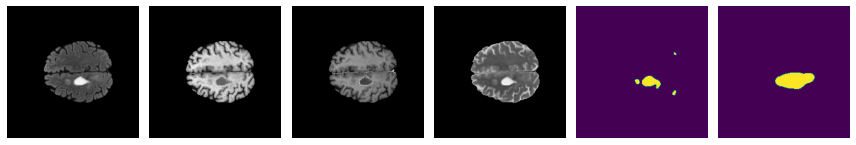

1029_18_4
(240, 240)
(240, 240, 155, 3)
[0. 1.]
[0 1]


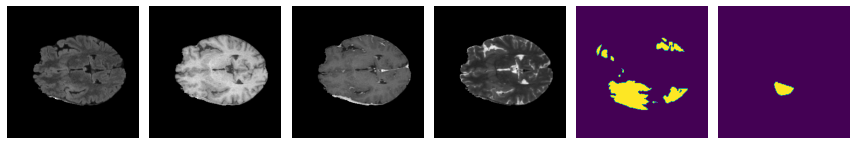

102_19_4
(240, 240)
(240, 240, 155, 3)
[0. 1.]
[0 1]


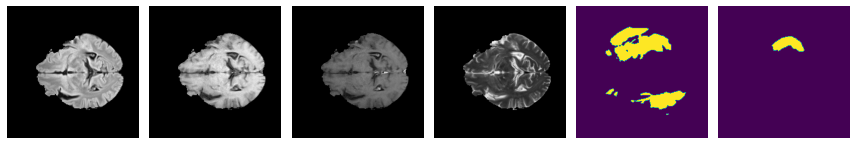

1032_19
(240, 240)
(240, 240, 155, 3)
[0. 1.]
[0 1]


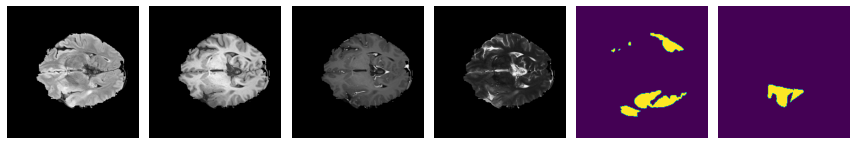

1034_18_4
(240, 240)
(240, 240, 155, 3)
[0. 1.]
[0 1]


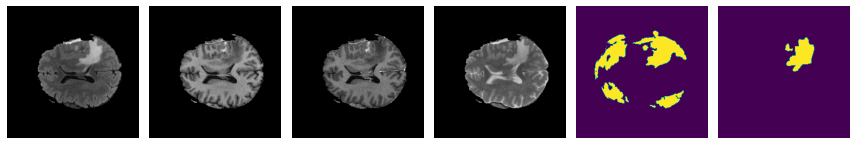

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 5, 110
data = sorted(glob("/results/glioma_infer/fold-0_brats/predictions_epoch=135-dice_mean=90_62_task=11_fold=0_tta/*.npy"))
for i, z in zip([0,2,3,4,5,6],[110,65,65,65, 80]):
    fname = data[i].split("/")[-1].split(".")[0]
    print(fname)
    img = nib.load(f"/data/private_data/brats_pipeline_out_train_GTV_brain/images/{fname}.nii.gz").get_fdata().astype(np.float32)
    label = nib.load(f"/data/private_data/brats_pipeline_out_train_GTV_brain/labels/{fname}_seg.nii.gz").get_fdata().astype(np.uint8)[:, :, z]
    pred = np.load(data[i])
#     pred = to_lbl(np.round(pred, 0))[:, :, z]
    pred = np.round(pred, 0).transpose(3,2,1,0)
    print(label.shape), print(pred.shape)
    print(np.unique(pred)), print(np.unique(label))
    imgs = [img[:, :, z, i] for i in [0, 1, 2, 3]] + [pred[:, :, z, 0]] + [label]    
    fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 12))
    for i in range(6):
        if i < 4:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 5, 110
data = sorted(glob("/results/glioma_infer/fold-0_brats/predictions_epoch=135-dice_mean=90_62_task=11_fold=0_tta/*.npy"))
for i in range(n):
    fname = data[i].split("/")[-1].split(".")[0]
    print(fname)
    img = nib.load(f"/data/private_data/brats_pipeline_out_train_GTV/images/{fname}.nii.gz").get_fdata().astype(np.float32)
    label = nib.load(f"/data/private_data/brats_pipeline_out_train_GTV/labels/{fname}_seg.nii.gz").get_fdata().astype(np.uint8)[:, :, z]
    pred = np.load(data[i])
#     pred = to_lbl(np.round(pred, 0))[:, :, z]
    pred = np.round(pred, 0).transpose(3,2,1,0)
    print(label.shape), print(pred.shape)
    print(np.unique(pred)), print(np.unique(label))
    imgs = [img[:, :, z, i] for i in [0, 3]] + [pred[:, :, z, 0]] + [label]    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
    for i in range(4):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()

0     0.844
1     0.838
2     0.849
3     0.860
4     0.802
       ... 
272   0.881
273   0.865
274   0.439
275   0.863
276   0.686
Name: Dice_2, Length: 277, dtype: float64


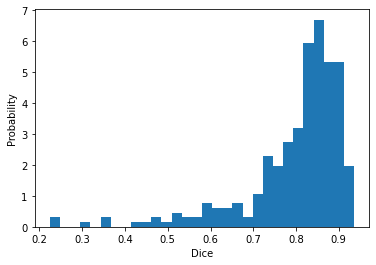

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

df = pd.read_csv('all_metris_glioma_right_label.csv')
print(df.Dice_2)
plt.hist(df.Dice_2, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Dice');


In [ ]:
df.Dice

In [ ]:
import seaborn as sns
df = pd.read_csv('all_metris_right_label.csv')
sns.displot(df.Dice, kde=True);